In [ ]:
import pandas as pd
import datetime as dt
import os
import sys
sys.path.append("../lib/")
from utils import *
from analysis import * 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
data = pd.read_csv("../Data/daneOkresoweKSE.csv", sep=';', skiprows=1, names=['Date', 'Hour', 'Minute', 'Load'])
Electric = data.copy()
Electric['Date'] = pd.to_datetime(Electric.Date)
Electric.loc[Electric.Hour == 24, 'Date'] = Electric.loc[Electric.Hour == 24, 'Date'] + dt.timedelta(days=1)
Electric.loc[Electric.Hour == 24, 'Hour'] = 0
Electric.Date = pd.to_datetime(Electric.Date.astype(str) + ' ' + Electric['Hour'].astype(str) + ':' + Electric.Minute.astype(str) + ':00')

Electric = Electric[['Date', 'Load']]
Electric['Minutes'] = Electric['Date'].dt.minute
Electric['Hour'] = Electric['Date'].dt.hour

In [3]:
Electric

,Date,Load,Minutes,Hour
0,2008-01-01 00:15:00,15938.8,15,0
1,2008-01-01 00:30:00,15770.4,30,0
2,2008-01-01 00:45:00,15766.3,45,0
3,2008-01-01 01:00:00,15415.2,0,1
4,2008-01-01 01:15:00,15351.8,15,1
...,...,...,...,...
315643,2016-12-31 23:00:00,15952.7,0,23
315644,2016-12-31 23:15:00,15865.3,15,23
315645,2016-12-31 23:30:00,15693.5,30,23
315646,2016-12-31 23:45:00,15508.3,45,23


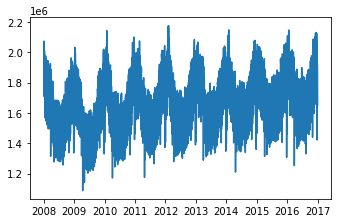

In [79]:
df = resampling_data(Electric, resample_cost='d')

df = df[~df.Load.isna()]
plt.plot(df.Date, df.Load)

In [80]:
df['Load_lin'] = linear_fit(x=df.index, y=df.Load)
df['Load_detrend'] = df.Load - df['Load_lin']

df.set_index('Date', inplace=True)
df

,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
Date,,,,,,,,
2008-01-02,11.5,22.5,1900414.4,2,False,2,1.651285e+06,249129.133128
2008-01-03,11.5,22.5,2023765.7,3,False,3,1.651331e+06,372435.015214
2008-01-04,11.5,22.5,2074081.7,4,False,4,1.651376e+06,422705.597300
2008-01-05,11.5,22.5,1910250.4,5,False,5,1.651422e+06,258828.879386
2008-01-06,11.5,22.5,1708630.0,6,False,6,1.651467e+06,57163.061472
...,...,...,...,...,...,...,...,...
2016-12-28,11.5,22.5,1920741.9,2,False,363,1.800392e+06,120349.621587
2016-12-29,11.5,22.5,1908350.9,3,False,364,1.800438e+06,107913.203674
2016-12-30,11.5,22.5,1875408.2,4,False,365,1.800483e+06,74925.085760


## Daily Load Sum SARIMA Forecasting

In [81]:
daily_Load = df[['Load_detrend']].copy()
daily_Load

,Load_detrend
Date,
2008-01-02,249129.133128
2008-01-03,372435.015214
2008-01-04,422705.597300
2008-01-05,258828.879386
2008-01-06,57163.061472
...,...
2016-12-28,120349.621587
2016-12-29,107913.203674
2016-12-30,74925.085760


C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


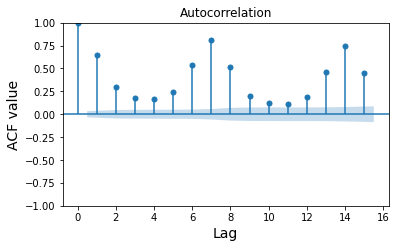

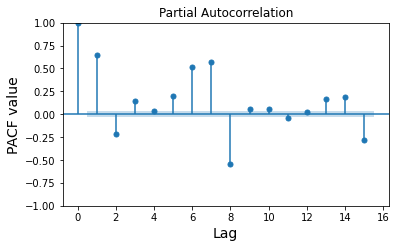

In [280]:
lag = 15
ax = latex_settings()
fig = sm.graphics.tsa.plot_acf(daily_Load, lags=lag, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('ACF value')
plt.savefig('../Images/SARIMAX/ACF_days.png')
"""file_path = '../Results/SARIMAX/'
file = f"Sarimax_results_{freq}_{n_days}days.csv"
if os.path.isfile(file_path + file):
    pass
else:    
    plt.savefig('../Images/SARIMAX/ACF_days.png')
plt.show()
plt.clf()
plt.close()"""

ax = latex_settings()
fig = sm.graphics.tsa.plot_pacf(daily_Load, lags=lag, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('PACF value')
plt.savefig('../Images/SARIMAX/PACF_days.png')
plt.show()
plt.clf()
plt.close()
(4,0,5) x (1,1,0,7)

In [241]:
sTest = StationarityTests()
sTest.kpss_Stationarity_Test(daily_Load['Load_detrend'])

sTest.Results

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Test Results
KPSS Test Statistic,0.303611
P-Value,0.1
# Lags Used,1
# Observations Used,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
Critical Value (10%),0.347
Critical Value (5%),0.463
Critical Value (2.5%),0.574
Critical Value (1%),0.739
Is the time series stationary?,Yes


In [242]:
forecast

,lower Load_detrend,upper Load_detrend
2016-12-23,140244.284009,463874.429297
2016-12-24,-100048.634136,223581.510733
2016-12-25,-303185.243976,91434.026310
2016-12-26,26042.798807,449774.316522
2016-12-27,63263.146757,502667.765658
2016-12-28,57004.363222,513992.454262
2016-12-29,67739.898871,536981.413073
2016-12-30,42734.169587,514230.596582
2016-12-31,-144144.815166,360133.934172
2017-01-01,-326362.201765,185810.055657


In [43]:
def sarimax_forecasting(df, cut_day, arima_args, seasonal_args):
    train_set = df[df.index < pd.to_datetime(cut_day, format='%Y-%m-%d')]
    # weekly: (1,0,9) x (2,1,0,52)
    # daily: (4,0,5) x (1,1,0,7) (or (4,1,5) x (1,1,0,7))
    # hourly: (8,0,30) x (1,1,1,24)
    model = SARIMAX(
        train_set, order=arima_args,
        seasonal_order=seasonal_args,
        freq=train_set.index.inferred_freq
        )
    fit_model = model.fit()
    forecast = fit_model.get_prediction(
        start=pd.to_datetime(cut_day, format='%Y-%m-%d'),
        end=df.index[-1]
        )
    return forecast.conf_int()
    

def save_sarimax_results(forecast, original_df, model): 
    df = forecast.copy()
    freq = df.index.inferred_freq 
    
    if freq == 'W-SUN':
        n_weeks = (pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[0])).days // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(df.index[0])).days
        time_interval = n_days
        interval_type = 'days'
    
    original_df = original_df[original_df.index >= df.index[0]].copy()
    
    df['mean Load'] = df.mean(axis=1)
    df['Load_lin'] = original_df.Load_lin
    # add the trend to the data
    df = df.add(df['Load_lin'], axis=0).iloc[:, :-1]
    df.columns = ['q1_forecast', 'q2_forecast', 'forecast']
    df.index.name = 'Date'

    file_path = '../Results/SARIMAX/'
    file = f"Sarimax_results_{time_interval}{interval_type}.csv"
    if os.path.isfile(file_path + file):
        pass
    else:    
        df.to_csv(file_path + file, index=True)

In [77]:
def plot_model_forecasting(df, cut_day, model, feature = 'Load'):
   
    freq = df.index.inferred_freq 
    if freq == 'W-SUN':
        weeks = 52
        n_weeks = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days // 7
        time_interval = n_weeks
        interval_type = 'weeks'     
    else:
        weeks = 2
        n_days = (pd.to_datetime(df.index[-1]) - pd.to_datetime(cut_day)).days
        time_interval = n_days
        interval_type = 'days'
        
    date = pd.to_datetime(cut_day) - dt.timedelta(weeks=weeks)
    cut_mask = df.index >= cut_day
    date_mask = df.index > date
 
    ax = latex_settings()
    df.loc[date_mask, [feature]].plot(ax=ax, color='b', lw=1)
    df.loc[cut_mask, [feature, 'forecast']].plot(ax=ax, color=['g', 'orange'], lw=1)
    ax.fill_between(x=df[date_mask].index, y1=df[date_mask].q1_forecast,
                    y2=df[date_mask].q2_forecast, color='orange', alpha=0.5, lw=1)
    ax.grid()
    ax.set_ylabel('Load (MW)')
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.set_title(f'Poland Electricity Load ({time_interval} {interval_type})')
    leg = plt.legend(loc="lower left", ncol=4, fancybox=True, framealpha=0.5,
                     fontsize=7.5,
                     labels=['Train set', 'Test set', 'Forecast', '95% CI'])

    file_path = f'../Images/{model}/'
    file = f'{model}_{freq}_{time_interval}{interval_type}.png'
    if os.path.isfile(file_path + file):
        pass
    else:    
        df.to_csv(file_path + file, index=True)
    
    plt.savefig(file_path + file, dpi=800, transparent=True)

In [42]:
cut_dates_days = ['2016-12-25', '2016-12-02', '2016-11-02']

for date in cut_dates_days:
    forecast  = sarimax_forecasting(daily_Load, date, (4,0,5), (1,1,0,7))
    save_sarimax_results(forecast, df)

NameError: name 'sarimax_forecasting' is not defined

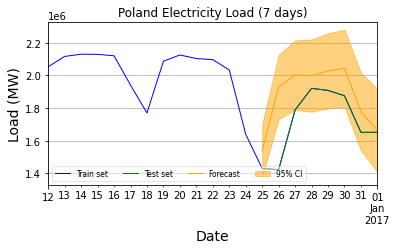

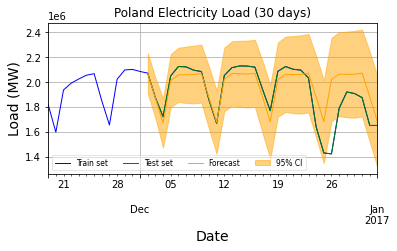

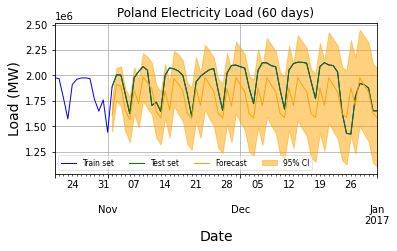

In [82]:
cut_dates_days = ['2016-12-25', '2016-12-02', '2016-11-02']
results_path = '../Results/SARIMAX/'

days = [7, 30, 60]

dfs = []
for ndays, cut_date in zip(days, cut_dates_days):
    file = f'Sarimax_results_D_{ndays}days.csv'
    res = pd.read_csv(results_path + file, index_col=['Date'], parse_dates=['Date'])
    tmp = df[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model='SARIMAX')
    
    dfs.append(tmp)

In [83]:
df = resampling_data(Electric, resample_cost='W')

df = df[~df.Load.isna()]
df

,Date,Hour,Minutes,Load,Day,Holiday,Day id
1,2008-01-13,11.500000,22.500000,13312844.7,6,False,13
2,2008-01-20,11.500000,22.500000,13109142.4,6,False,20
3,2008-01-27,11.500000,22.500000,12963823.6,6,False,27
4,2008-02-03,11.500000,22.500000,12932126.7,6,False,34
5,2008-02-10,11.500000,22.500000,12755617.7,6,False,41
...,...,...,...,...,...,...,...
465,2016-12-04,11.500000,22.500000,13978036.2,6,False,339
466,2016-12-11,11.500000,22.500000,14004313.2,6,False,346
467,2016-12-18,11.500000,22.500000,14259329.9,6,False,353
468,2016-12-25,11.500000,22.500000,13515059.4,6,True,360


In [84]:
df['Load_lin'] = linear_fit(x=df.index, y=df.Load)
df['Load_detrend'] = df.Load - df['Load_lin']

df.set_index('Date', inplace=True)
df

,Hour,Minutes,Load,Day,Holiday,Day id,Load_lin,Load_detrend
Date,,,,,,,,
2008-01-13,11.500000,22.500000,13312844.7,6,False,13,1.154473e+07,1.768117e+06
2008-01-20,11.500000,22.500000,13109142.4,6,False,20,1.154703e+07,1.562116e+06
2008-01-27,11.500000,22.500000,12963823.6,6,False,27,1.154932e+07,1.414499e+06
2008-02-03,11.500000,22.500000,12932126.7,6,False,34,1.155162e+07,1.380504e+06
2008-02-10,11.500000,22.500000,12755617.7,6,False,41,1.155392e+07,1.201697e+06
...,...,...,...,...,...,...,...,...
2016-12-04,11.500000,22.500000,13978036.2,6,False,339,1.261117e+07,1.366869e+06
2016-12-11,11.500000,22.500000,14004313.2,6,False,346,1.261347e+07,1.390847e+06
2016-12-18,11.500000,22.500000,14259329.9,6,False,353,1.261576e+07,1.643566e+06


In [85]:
weekly_Load = df[['Load_detrend']].copy()
weekly_Load

,Load_detrend
Date,
2008-01-13,1.768117e+06
2008-01-20,1.562116e+06
2008-01-27,1.414499e+06
2008-02-03,1.380504e+06
2008-02-10,1.201697e+06
...,...
2016-12-04,1.366869e+06
2016-12-11,1.390847e+06
2016-12-18,1.643566e+06


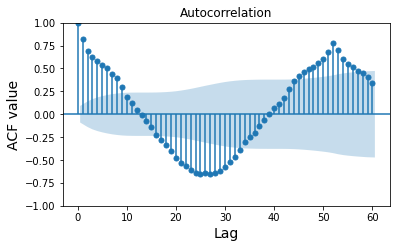

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


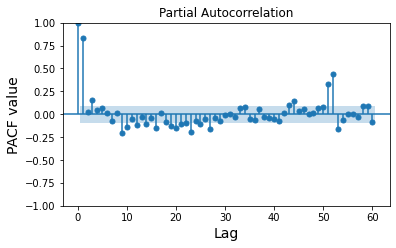

In [272]:
lag = 60
ax = latex_settings()
fig = sm.graphics.tsa.plot_acf(weekly_Load, lags=lag, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('ACF value')
plt.savefig('../Images/SARIMAX/ACF_weeks.png')
plt.show()
plt.clf()
plt.close()

ax = latex_settings()
fig = sm.graphics.tsa.plot_pacf(weekly_Load, lags=lag, ax=ax)
ax.set_xlabel('Lag')
ax.set_ylabel('PACF value')
plt.savefig('../Images/SARIMAX/PACF_weeks.png')
plt.show()
plt.clf()
plt.close()

In [251]:
sTest = StationarityTests()
sTest.kpss_Stationarity_Test(weekly_Load['Load_detrend'])

sTest.Results

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\stattools.py:2015: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,KPSS Test Results
KPSS Test Statistic,0.084688
P-Value,0.1
# Lags Used,1
# Observations Used,"{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%..."
Critical Value (10%),0.347
Critical Value (5%),0.463
Critical Value (2.5%),0.574
Critical Value (1%),0.739
Is the time series stationary?,Yes


In [255]:
cut_dates_weeks = ['2016-07-01', '2015-07-01', '2014-07-01']

for date in cut_dates_weeks:
    forecast = sarimax_forecasting(weekly_Load, date, (1,0,9), (2,1,0,52)) 
    save_sarimax_results(forecast, df)

C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'
C:\Users\manue\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  warnings.warn('No frequency information was'


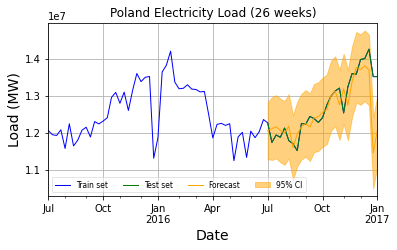

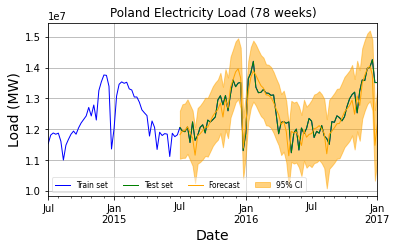

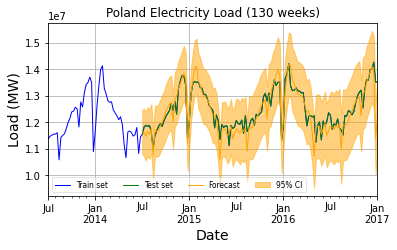

In [86]:
cut_dates_weeks = ['2016-07-01', '2015-07-01', '2014-07-01']
results_path = '../Results/SARIMAX/'

days = [182, 546, 910]

dfs = []
for ndays, cut_date in zip(days, cut_dates_weeks):
    file = f'Sarimax_results_W-SUN_{ndays}days.csv'
    res = pd.read_csv(results_path + file, index_col=['Date'], parse_dates=['Date'])
    tmp = df[['Load']].copy()
    tmp.loc[res.index, res.columns] = res    
    
    plot_model_forecasting(df=tmp, cut_day=cut_date, model='SARIMAX')
    
    dfs.append(tmp)